# Anomaly detection from images using convolutional autoencoders

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
import pickle

## Defining generators for training, validation and anomaly data.

In [2]:
SIZE = 448

batch_size = 16

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'metal_nut/good_train/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    'metal_nut/good_test/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    'metal_nut/bad/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 220 images belonging to 1 classes.
Found 22 images belonging to 1 classes.
Found 93 images belonging to 1 classes.


## Defining the autoencoder model

In [4]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
# model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 256, 256, 32)     0

## Fitting the model

Epoch 1/30
13/13 [==============================] - 432s 33s/step - loss: 0.0753 - mse: 0.0753 - val_loss: 0.0544 - val_mse: 0.0544
Epoch 2/30
13/13 [==============================] - 222s 17s/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 3/30
13/13 [==============================] - 191s 15s/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 4/30
13/13 [==============================] - 164s 13s/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 5/30
13/13 [==============================] - 159s 12s/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 6/30
13/13 [==============================] - 164s 13s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 7/30
13/13 [==============================] - 158s 12s/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/30
13/13 [==============================] - 161s 12s/step - loss: 0.

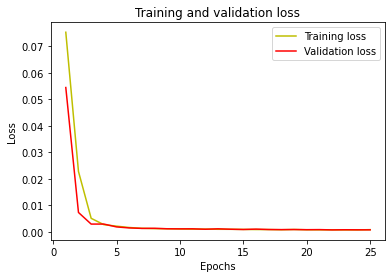

In [5]:
history = model.fit(
        train_generator,
        steps_per_epoch= 220 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=22 // batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
        shuffle = True)


# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# for saving the trained model

# with open('AE_model.pkl', 'wb') as file:
#     pickle.dump(model, file)

INFO:tensorflow:Assets written to: ram://06893ba5-de99-420c-90cf-8a3bf68212e0/assets


In [ ]:
# for loading the trained model

# with open('AE_model.pkl', 'rb') as file:
#     model = pickle.load(file)

## Predicting first batch of images 

In [7]:
# Get all batches generated by the datagen and pick a batch for prediction

data_batch = []  
img_num = 0
while img_num <= train_generator.batch_index:
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])

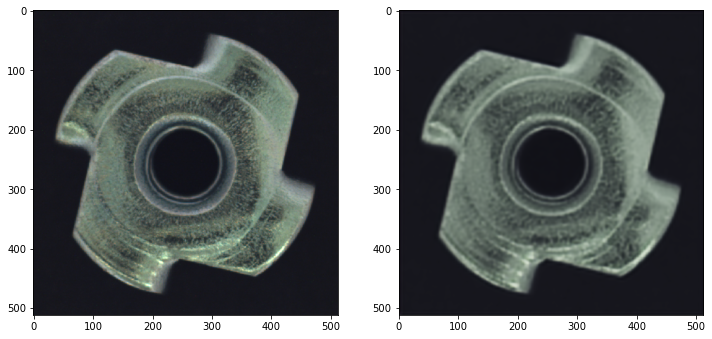

In [8]:
# Sanity check, view few images and corresponding reconstructions
import random

image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

## Building the encoder network with trained weights

In [9]:
# This is used to get the compressed output (latent space) of the input image. 
# The compressed output is then used to calculate the KDE

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
# encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
# encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 512, 512, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 256, 256, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
Total params: 20,256
Trainable params: 20,256
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Get encoded output of input images
encoded_images = encoder_model.predict(train_generator)

# Flatten the encoded output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape

out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

# Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector) 

## Reconstruction error for validation and anomaly data

In [11]:
validation_error = model.evaluate(validation_generator)
anomaly_error = model.evaluate(anomaly_generator)

print("Reconstruction error for the validation (normal) data is: ", validation_error[0])
print("Reconstruction error for the anomaly data is: ", anomaly_error[0])

6/6 [==============================] - 11s 2s/step - loss: 6.2697e-04 - mse: 6.2697e-04
Reconstruction error for the validation (normal) data is:  0.000705390062648803
Reconstruction error for the anomaly data is:  0.0006269679288379848


## Threshold for reconstruction error and KDE

In [32]:
# Calculate reconstruction error and KDE to find their range for good and anomaly images. 
# We use these to set thresholds. 


def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        
        encoded_img = encoder_model.predict([[img]]) 
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
        
        density = kde.score_samples(encoded_img)[0] 
        
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
#     average_density = np.mean(np.array(density_list))  
#     stdev_density = np.std(np.array(density_list)) 
    
#     average_recon_error = np.mean(np.array(recon_error_list))  
#     stdev_recon_error = np.std(np.array(recon_error_list)) 
    
#     return average_density, stdev_density, average_recon_error, stdev_recon_error

    return min(density_list), max(density_list), min(recon_error_list), max(recon_error_list)

# Get range of kde, reconstruction error for good and anomaly images
# For this generate a batch of images for each
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

good_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

print('Range of KDE, Reconstruction error for good images', good_values)
print('Range of KDE, Reconstruction error for anomaly images', anomaly_values)

1/1 [==============================] - 0s 150ms/step - loss: 0.0015 - mse: 0.0015
Range of KDE, Reconstruction error for good images (362015.14490989177, 362015.14490989177, 0.0013309455243870616, 0.0018553708214312792)
Range of KDE, Reconstruction error for anomaly images (357167.80022662407, 361863.0004713425, 0.0014003755059093237, 0.0017469023587182164)


## Check for anomalies

In [52]:
# Input unknown images and sort as Good or Anomaly

def check_anomaly(img_path):
    
    density_threshold = 361864
    recon_error_threshold = 0.002
    
    img  = Image.open(img_path)
    img = np.array(img.resize((512, 512), Image.ANTIALIAS))
    plt.imshow(img)
    img = img/255.
    img = img[np.newaxis, :, :, :]
    
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    recon_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or recon_error > recon_error_threshold:
        print(f"The image is an anomaly. KDE={density} and recon_error={recon_error}")
        
    else:
        print(f"The image is NOT an anomaly.  KDE={density} and recon_error={recon_error}")

In [53]:
# Load a couple of test images and verify whether they are reported as anomalies.
import glob
bad_file_paths = glob.glob('metal_nut/bad/images/*')
good_file_paths = glob.glob('metal_nut/good_train/images/*')

1/1 [==============================] - 0s 118ms/step - loss: 0.0017 - mse: 0.0017
The image is an anomaly. KDE=358964.0092375598 and recon_error=0.0016526691615581512


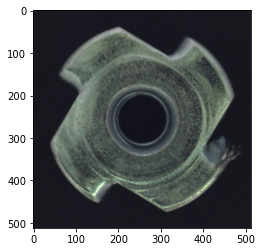

In [60]:
# Anomaly image verification
num = random.randint(0, len(bad_file_paths)-1)
check_anomaly(bad_file_paths[num])

1/1 [==============================] - 0s 140ms/step - loss: 0.0017 - mse: 0.0017
The image is NOT an anomaly.  KDE=361977.7092309444 and recon_error=0.0016828812658786774


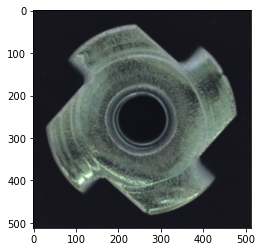

In [55]:
# Good/normal image verification
num = random.randint(0, len(good_file_paths)-1)
check_anomaly(good_file_paths[num])